In [83]:
import matplotlib.pyplot as plt
import numpy as np
import logging
from time import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import random
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from scipy.special import softmax
from torch.utils.data import DataLoader

tf.autograph.set_verbosity(0, False)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [111]:
SEQ_LENGTH = 250

corpus = open("dataset.txt", 'r').read()
corpus = corpus.lower()

In [112]:
chars = sorted(list(set(corpus)))
char_to_id = {c: i for i, c in enumerate(chars)}
id_to_char = {i: c for i, c in enumerate(chars)}
vocab_size = len(chars)
tokenized_inputs = []
tokenized_outputs = []
for i in tqdm(range(0, len(corpus) - SEQ_LENGTH - 1, 251)):
    tokenized_inputs.append([char_to_id[c] for c in corpus[i: i + SEQ_LENGTH]])
    tokenized_outputs.append([char_to_id[c] for c in corpus[i + 1: i + SEQ_LENGTH + 1]])
tokenized_inputs = np.array(tokenized_inputs)
tokenized_outputs = np.array(to_categorical(tokenized_outputs, vocab_size))
x_train, x_test, y_train, y_test = train_test_split(tokenized_inputs, 
                                                    tokenized_outputs, 
                                                    test_size=0.1, random_state=42)
print("CHAR To ID:", char_to_id)
print("Inputs:", x_train.shape, x_test.shape, "Outputs:", y_train.shape, y_test.shape)

  0%|          | 0/4412 [00:00<?, ?it/s]

CHAR To ID: {'\t': 0, '\n': 1, ' ': 2, '!': 3, '"': 4, "'": 5, '(': 6, ')': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '6': 17, '7': 18, '9': 19, ':': 20, ';': 21, '?': 22, '^': 23, '_': 24, 'a': 25, 'b': 26, 'c': 27, 'd': 28, 'e': 29, 'f': 30, 'g': 31, 'h': 32, 'i': 33, 'j': 34, 'k': 35, 'l': 36, 'm': 37, 'n': 38, 'o': 39, 'p': 40, 'q': 41, 'r': 42, 's': 43, 't': 44, 'u': 45, 'v': 46, 'w': 47, 'x': 48, 'y': 49, 'z': 50, '}': 51, '¢': 52, '¼': 53, 'â': 54, 'ã': 55, '€': 56}
Inputs: (3970, 250) (442, 250) Outputs: (3970, 250, 57) (442, 250, 57)


# a)

In [177]:
class RNN_Trainer:
    def __init__(self, vocab_size, seq_length, rnn="LSTM", activation_function="relu", 
                 optimizer="adam", loss_function='categorical_crossentropy', units=1024) -> None:
        self.optimizer = optimizer
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.rnn = rnn
        self.seq_length = seq_length
        self.model = self.build_model(vocab_size, seq_length, units)
        self.history = None
        self.training_time = None
    
    def build_model(self, vocab_size, seq_length, units):
        rnn_map = {
            "SimpleRNN": tf.keras.layers.SimpleRNN(units, return_sequences=True),
            "GRU": tf.keras.layers.GRU(units, return_sequences=True, dropout=0.0),
            "LSTM": tf.keras.layers.LSTM(units, return_sequences=True, dropout=0.0),
        }
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=seq_length),
            rnn_map[self.rnn],
            tf.keras.layers.Dense(256, activation=self.activation_function),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation=self.activation_function),
            tf.keras.layers.Dense(vocab_size, activation='softmax')
        ])
        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_function,
            metrics=['accuracy']
        )
        return model
    
    def train(self, tokenized_inputs, tokenized_outputs, batch_size=64, epochs=5):
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=3,
            mode='min',
            restore_best_weights=True
        )
        self.history = self.model.fit(
            tokenized_inputs, tokenized_outputs,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.1,
            callbacks=[early_stopping],
        )
        
    def plot_history(self):
        fig = plt.figure(figsize=(12, 4))
        metrics = ['loss', 'accuracy']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 2, n+1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()
    
    def evaluate(self, x_test, y_test):
        [test_loss,test_acc] = self.model.evaluate(x_test, y_test)
        print("Test Loss:", test_loss, "Test Accuracy:", test_acc)
        test_preds = np.argmax(self.model.predict(x_test), axis=-1)
        y_test = np.argmax(y_test, axis=-1)
        
    def predict(self, start_str="ma", argmax=True, temperature=0.5):
        tokenized_current = [char_to_id[c] for c in start_str]
        for i in tqdm(range(len(tokenized_current), self.seq_length)):
            mask = np.zeros(self.seq_length)
            mask[:i] = 1
            input_ids = np.zeros(self.seq_length)
            input_ids[:i] = tokenized_current
            predicted_logits = self.model(inputs=np.array([input_ids]), mask=mask)
            if argmax:
                next_id = np.argmax(predicted_logits, axis=-1)[0][i - 1]
            else:
                predicted_logits = predicted_logits / temperature
                next_id = tf.random.categorical(predicted_logits[:, i - 1, :], num_samples=1).numpy()[0][0]
            tokenized_current.append(next_id)
        return "".join([id_to_char[id] for id in tokenized_current])
        

In [183]:
trainer = RNN_Trainer(vocab_size, SEQ_LENGTH,
#                       optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2)
                     )
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=10)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 250, 64)           3648      
                                                                 
 lstm_32 (LSTM)              (None, 250, 1024)         4460544   
                                                                 
 dense_88 (Dense)            (None, 250, 256)          262400    
                                                                 
 dropout_32 (Dropout)        (None, 250, 256)          0         
                                                                 
 dense_89 (Dense)            (None, 250, 128)          32896     
                                                                 
 dense_90 (Dense)            (None, 250, 57)           7353      
                                                                 
Total params: 4,766,841
Trainable params: 4,766,841
N

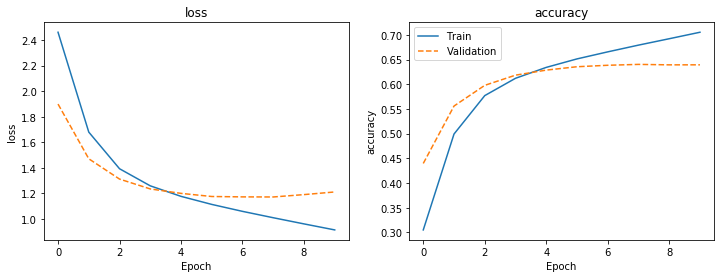

14/14 [==============================] - 1s 50ms/step - loss: 1.2015 - accuracy: 0.6430
Test Loss: 1.2014552354812622 Test Accuracy: 0.6429864168167114


In [184]:
trainer.plot_history()
trainer.evaluate(x_test, y_test)  # 6534 24s

In [187]:
print(trainer.predict("fred and george", argmax=True))
print(trainer.predict("master", argmax=True))
print(trainer.predict("he was very fond of his map, but on the other hand, he was extremely", argmax=True))
print(trainer.predict("harry", argmax=True))

  0%|          | 0/235 [00:00<?, ?it/s]

fred and george were standing up and started to see what had happened to the statue the stars of the stands of the wands were still gazing around the corridors an extraordinary invisibility cloak and then said, "and then he could have been a bit of a


  0%|          | 0/244 [00:00<?, ?it/s]

master and showing him and she was still staring at her.
"you have been a bit of a friend," said harry.  "i was still in the common room and forgetting the dark arts teacher will be able to stop himself in my office on the way they were all right?"
"


  0%|          | 0/182 [00:00<?, ?it/s]

he was very fond of his map, but on the other hand, he was extremely took off against the darkness and the sounds of the wand was still staring at her.  "i have a great strange of magical creatures, is it?"  said hermione sharply.  "i had a few moden


  0%|          | 0/245 [00:00<?, ?it/s]

harry was standing up and saw that he was still gazing at him.  he was standing up and saw that he was still staring at her.
"you have been a bit of a friend," said harry.  "i was still in the common room and forgetting the dark arts teacher will be 


In [188]:
temp = 0.02
print(trainer.predict("fred and george", argmax=False, temperature=temp))
print(trainer.predict("master", argmax=False, temperature=temp))
print(trainer.predict("he was very fond of his map, but on the other hand, he was extremely", argmax=False, temperature=temp))
print(trainer.predict("harry", argmax=False, temperature=temp))

  0%|          | 0/235 [00:00<?, ?it/s]

fred and george were standing up and saw that he was still gazing at him.
"you have been anyway."
"yeah, i know what you wouldn't be able to read the mark when i was the one who was still in the common room and began to call any more than the same so


  0%|          | 0/244 [00:00<?, ?it/s]

master and remotely took off the  master and move.  he was passed them and watched him and walked out of the castle and then said, "and then he could not be  every now and then i had a great straight of magical creatures who would have been anything 


  0%|          | 0/182 [00:00<?, ?it/s]

he was very fond of his map, but on the other hand, he was extremely took off again.  he was standing up and started to see what was coming on the floor.  he was standing up and started to see what had happened.  he was standing up and started to see


  0%|          | 0/245 [00:00<?, ?it/s]

harry was standing on the floor.  "i was still in the first task."
"you don't think so," said harry.
"well, i was only to be an idiot, harry?"  he said, standing up and saw that he was standing up and saw that he was standing up and saw that he was s


In [198]:
print(trainer.predict("hadiloo loved ", argmax=True))

  0%|          | 0/236 [00:00<?, ?it/s]

hadiloo loved the stands, the sound of the way the stars on the grounds and was still staring at her.
"you have been a bit of a friend," said harry.  "i was still in the common room and forgetting the dark arts teacher will be able to stop himself in


# b)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 250, 64)           3648      
                                                                 
 lstm_33 (LSTM)              (None, 250, 1024)         4460544   
                                                                 
 dense_91 (Dense)            (None, 250, 256)          262400    
                                                                 
 dropout_33 (Dropout)        (None, 250, 256)          0         
                                                                 
 dense_92 (Dense)            (None, 250, 128)          32896     
                                                                 
 dense_93 (Dense)            (None, 250, 57)           7353      
                                                                 
Total params: 4,766,841
Trainable params: 4,766,841
N

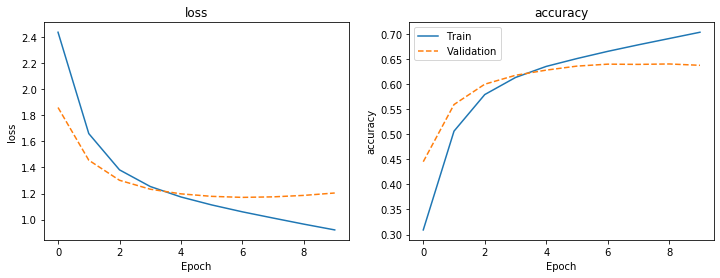

14/14 [==============================] - 1s 50ms/step - loss: 1.1689 - accuracy: 0.6401
Test Loss: 1.1689121723175049 Test Accuracy: 0.6400905251502991


In [199]:
trainer = RNN_Trainer(vocab_size, SEQ_LENGTH,
                      loss_function=tf.keras.losses.KLDivergence()
                     )
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=10)
trainer.plot_history()
trainer.evaluate(x_test, y_test)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 250, 64)           3648      
                                                                 
 lstm_35 (LSTM)              (None, 250, 1024)         4460544   
                                                                 
 dense_97 (Dense)            (None, 250, 256)          262400    
                                                                 
 dropout_35 (Dropout)        (None, 250, 256)          0         
                                                                 
 dense_98 (Dense)            (None, 250, 128)          32896     
                                                                 
 dense_99 (Dense)            (None, 250, 57)           7353      
                                                                 
Total params: 4,766,841
Trainable params: 4,766,841
N

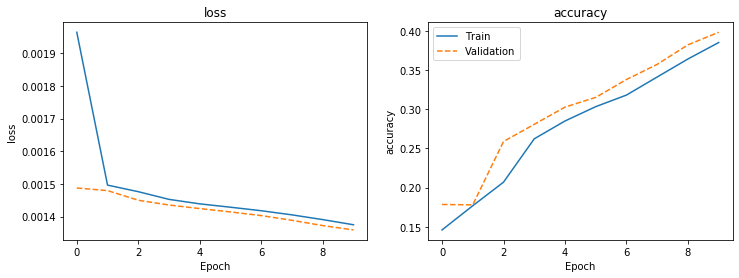

14/14 [==============================] - 1s 52ms/step - loss: 0.0014 - accuracy: 0.3976
Test Loss: 0.0013581027742475271 Test Accuracy: 0.3975837230682373


In [204]:
trainer = RNN_Trainer(vocab_size, SEQ_LENGTH,
                      loss_function=tf.keras.losses.BinaryFocalCrossentropy()
                     )
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=10)
trainer.plot_history()
trainer.evaluate(x_test, y_test)

# c)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 250, 64)           3648      
                                                                 
 lstm_36 (LSTM)              (None, 250, 1024)         4460544   
                                                                 
 dense_100 (Dense)           (None, 250, 256)          262400    
                                                                 
 dropout_36 (Dropout)        (None, 250, 256)          0         
                                                                 
 dense_101 (Dense)           (None, 250, 128)          32896     
                                                                 
 dense_102 (Dense)           (None, 250, 57)           7353      
                                                                 
Total params: 4,766,841
Trainable params: 4,766,841
N

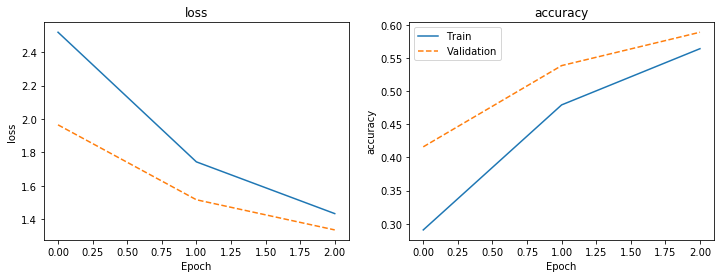

14/14 [==============================] - 1s 52ms/step - loss: 1.3318 - accuracy: 0.5896
Test Loss: 1.3317735195159912 Test Accuracy: 0.5896470546722412


In [205]:
# EPOCH 3
trainer = RNN_Trainer(vocab_size, SEQ_LENGTH)
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=3)
trainer.plot_history()
trainer.evaluate(x_test, y_test)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 250, 64)           3648      
                                                                 
 lstm_37 (LSTM)              (None, 250, 1024)         4460544   
                                                                 
 dense_103 (Dense)           (None, 250, 256)          262400    
                                                                 
 dropout_37 (Dropout)        (None, 250, 256)          0         
                                                                 
 dense_104 (Dense)           (None, 250, 128)          32896     
                                                                 
 dense_105 (Dense)           (None, 250, 57)           7353      
                                                                 
Total params: 4,766,841
Trainable params: 4,766,841
N

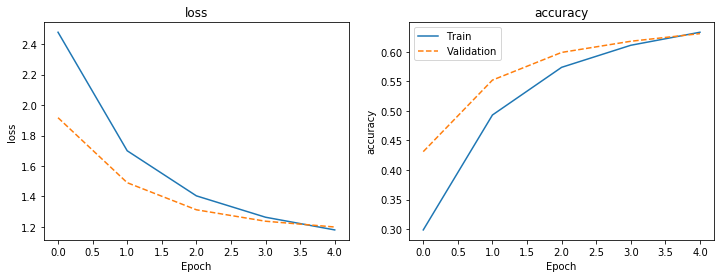

14/14 [==============================] - 1s 51ms/step - loss: 1.1919 - accuracy: 0.6322
Test Loss: 1.191850185394287 Test Accuracy: 0.6321991086006165


In [206]:
# EPOCH 5
trainer = RNN_Trainer(vocab_size, SEQ_LENGTH)
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=5)
trainer.plot_history()
trainer.evaluate(x_test, y_test)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 250, 64)           3648      
                                                                 
 gru_38 (GRU)                (None, 250, 1024)         3348480   
                                                                 
 dense_106 (Dense)           (None, 250, 256)          262400    
                                                                 
 dropout_38 (Dropout)        (None, 250, 256)          0         
                                                                 
 dense_107 (Dense)           (None, 250, 128)          32896     
                                                                 
 dense_108 (Dense)           (None, 250, 57)           7353      
                                                                 
Total params: 3,654,777
Trainable params: 3,654,777
N

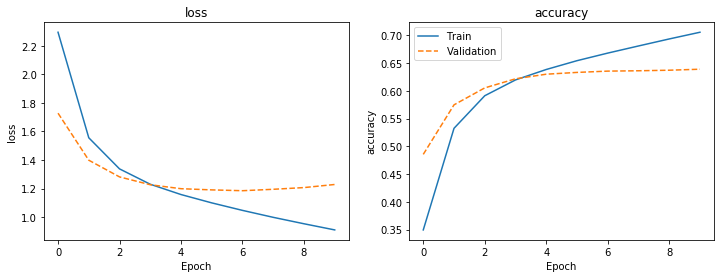

14/14 [==============================] - 1s 36ms/step - loss: 1.1775 - accuracy: 0.6388
Test Loss: 1.1775251626968384 Test Accuracy: 0.6387692093849182


In [207]:
# GRU
trainer = RNN_Trainer(vocab_size, SEQ_LENGTH, rnn="GRU")
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=10)
trainer.plot_history()
trainer.evaluate(x_test, y_test)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 250, 64)           3648      
                                                                 
 lstm_39 (LSTM)              (None, 250, 1024)         4460544   
                                                                 
 dense_109 (Dense)           (None, 250, 256)          262400    
                                                                 
 dropout_39 (Dropout)        (None, 250, 256)          0         
                                                                 
 dense_110 (Dense)           (None, 250, 128)          32896     
                                                                 
 dense_111 (Dense)           (None, 250, 57)           7353      
                                                                 
Total params: 4,766,841
Trainable params: 4,766,841
N

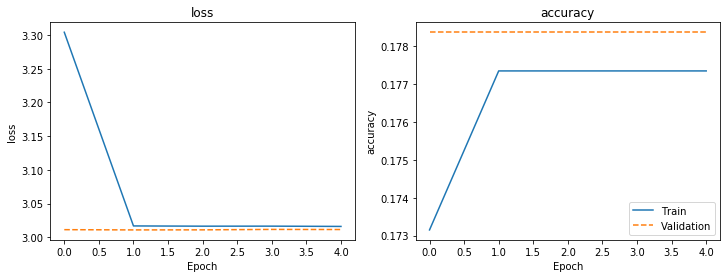

14/14 [==============================] - 1s 52ms/step - loss: 3.0160 - accuracy: 0.1773
Test Loss: 3.0159547328948975 Test Accuracy: 0.17733031511306763


In [210]:
# LR
trainer = RNN_Trainer(vocab_size, SEQ_LENGTH,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1)
                     )
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=10)
trainer.plot_history()
trainer.evaluate(x_test, y_test)